# 1, Data preprocessing

In [1]:
# https://stackoverflow.com/questions/54473254/cudnnlstm-unknownerror-fail-to-find-the-dnn-implementation

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [2]:
# set random seed
tf.random.set_seed(1234)

### 1, Load and extract the data

In [3]:
### extracting the entities and tags

import os 
from tensorflow.keras.preprocessing.sequence import pad_sequences


def split_text_label(filename):
    '''
    Reads a file named filename, extracts the text and the labels and stores
    them in an array.
     
    returns [ ['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O'] ] 
    '''
    
    # open file
    f = open(filename)
    
    # initializing
    split_labeled_text = []
    sentence = []
    
    # processing line by line 
    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\t":
            if len(sentence) > 0:
                split_labeled_text.append(sentence)
                sentence = []
            continue
        
        # split by tab
        splits = line.split('	')
        # rstrip: strip from the right 
        sentence.append([splits[0],splits[-1].rstrip("\n")])
        
        
    if len(sentence) > 0:
        split_labeled_text.append(sentence)
        sentence = []
    return split_labeled_text



### Loading in the Raw_Corpus and split into train, valid, test

In [4]:
training_path = r'C:\Users\15680\KG4\Fine_tuning_NER\data\training_set_12_20.txt'

testing_path = r'C:\Users\15680\KG4\Fine_tuning_NER\data\testing_set_12_20.txt'

rich_sent_path = r'C:\Users\15680\KG4\Fine_tuning_NER\data\rich_sentence_from_training_set_12_20.txt'


In [40]:
# load in data
split_train = split_text_label(training_path)

# load in data
split_test = split_text_label(testing_path)

# load in data
split_agu = split_text_label(rich_sent_path)

# set the data variable name 
split_valid = split_test
split_train_agu = split_train + split_agu


print("Length of training data: ", len(split_train))
print()
print("Length of testing data: ", len(split_test))
print()
print("Length of agumentation data: ", len(split_train_agu))
print()

Length of training data:  911

Length of testing data:  374

Length of agumentation data:  1589



In [41]:
# print some list to see 

print("training data: ", split_train[0:1])
print()

print("validing data: ", split_valid[0:1])
print()

print("testing data: ", split_test[0:1])
print()

print("train_agu: ", split_train_agu[0:1])
print()

training data:  [[['a', 'O'], ['host', 'O'], ['ofsignaling', 'O'], ['molecules', 'O'], ['are', 'O'], ['released', 'O'], ['by', 'O'], ['activated', 'O'], ['immune', 'O'], ['cellsincluding', 'O'], ['inflammatory', 'O'], ['mediators', 'O'], ['such', 'O'], ['as', 'O'], ['prostaglandinsand', 'O'], ['cytokines', 'O']]]

validing data:  [[['cows', 'O'], ['that', 'O'], ['develop', 'O'], ['displacement', 'B-DIS'], ['of', 'I-DIS'], ['abomasum', 'I-DIS'], ['have', 'O'], ['delayed', 'O'], ['postpartum', 'O'], ['insemination', 'O'], ['raizman', 'O'], ['and', 'O'], ['santos', 'O'], ['2002', 'O'], ['which', 'O'], ['might', 'O'], ['decrease', 'O'], ['reproductive', 'O'], ['efficiency', 'O']]]

testing data:  [[['cows', 'O'], ['that', 'O'], ['develop', 'O'], ['displacement', 'B-DIS'], ['of', 'I-DIS'], ['abomasum', 'I-DIS'], ['have', 'O'], ['delayed', 'O'], ['postpartum', 'O'], ['insemination', 'O'], ['raizman', 'O'], ['and', 'O'], ['santos', 'O'], ['2002', 'O'], ['which', 'O'], ['might', 'O'], ['decrea

### ===== trying with or without agu data 

In [42]:
### try one with augmented data 

split_train = split_train_agu

# without data sgu


### 2, Buidling Vocabulary

### build a vocabulary for the text, so we can assign a unique index for each word

In [43]:
### use labelSet() as label dictionary 
### use wordSet() as word dictionary 

labelSet = set()
wordSet = set()
# words and labels
for data in [split_train, split_valid, split_test]:
    for labeled_text in data:
        for word, label in labeled_text:
            
            # modifying unwanted mistag
            if label == 'i-NUT':
                label = 'I-NUT'
            if label == '':
                label = 'O'
            
            
            labelSet.add(label)
            wordSet.add(word.lower())
            


# modifying the label set 
print()
#empty = labelSet.pop()
#labelSet.remove('"performance')
#labelSet.remove('"results')
#labelSet.remove('"cow')
#labelSet.remove('"cows')
#labelSet.remove('"ration')
#labelSet.remove('"cattle')
#labelSet.remove('"2000)')
#labelSet.remove('"in')
#labelSet.remove('"')
#labelSet.remove('"e')
#labelSet.remove('"disorders')
#labelSet.remove('"staggers')

# check for the len 
print("labelSet: ", len(labelSet))
print("labelSet: ", labelSet)
print()
print("wordSet: ", len(wordSet))



labelSet:  5
labelSet:  {'B-DIS', 'I-NUT', 'O', 'I-DIS', 'B-NUT'}

wordSet:  4451


### 3, Assiging index 

In [44]:
### label2Idx  word2Idx


# sort the set to ensure '0' is assigned to 0
sorted_labels = sorted(list(labelSet), key=len)


# create mapping for labels
label2Idx = {}
for label in sorted_labels:
    label2Idx[label] = len(label2Idx)
idx2Label = {v: k for k, v in label2Idx.items()}


# create mapping for words
word2Idx = {}
if len(word2Idx) == 0:
    word2Idx["PADDING_TOKEN"] = len(word2Idx) # as 0
    word2Idx["UNKNOWN_TOKEN"] = len(word2Idx) # as 1
for word in wordSet:
    word2Idx[word] = len(word2Idx)
    
# print some mapping 

print("idx2Label: ", len(idx2Label))
print("idx2Label: ", idx2Label)
print()
print("word2Idx: ", len(word2Idx))
print("word2Idx: ", word2Idx)

idx2Label:  5
idx2Label:  {0: 'O', 1: 'B-DIS', 2: 'I-NUT', 3: 'I-DIS', 4: 'B-NUT'}

word2Idx:  4453
word2Idx:  {'PADDING_TOKEN': 0, 'UNKNOWN_TOKEN': 1, 'cheng': 2, 'repeated': 3, 'cholineor': 4, 'keyrole': 5, 'me': 6, 'specifically': 7, '600kg': 8, 'morant': 9, 'ones': 10, 'similar': 11, 'curve': 12, 'clinicalsigns': 13, 'dry': 14, 'exacerbated': 15, 'hypocalcaemia': 16, '80': 17, 'conflicting': 18, 'hypothesis': 19, 'al2003': 20, 'urgently': 21, 'assume': 22, 'said': 23, 'cowsinterest': 24, 'ts': 25, 'adult': 26, 'water': 27, 'inherently': 28, '0451': 29, 'body': 30, 'leukosis': 31, 'timeframe': 32, 'ucd': 33, 'snapshot': 34, 'aggravated': 35, 'roche': 36, 'infectionlikely': 37, 'closely': 38, 'improvedingvartsen': 39, 'protocols': 40, 'pay': 41, 'exist': 42, 'acute': 43, 'however': 44, 'limited': 45, 'predisposes': 46, 'locking': 47, '48': 48, 'fertility': 49, 'pose': 50, 'chopping': 51, 'elongate': 52, 'al2000': 53, '08': 54, 'consecutive': 55, 'elimination': 56, 'oligonucleotide': 

### 4, Change words into representive index

In [45]:
def createMatrices(data, word2Idx, label2Idx):
    sentences = []
    labels = []
    
    # get data 
    for split_labeled_text in data:
        wordIndices = []
        labelIndices = []
        
        # get word and data
        for word, label in split_labeled_text:
            
            try:
                # if is in the vocabulary
                if word in word2Idx:
                    wordIdx = word2Idx[word]

                # if the lower case version is in the vocabulary
                elif word.lower() in word2Idx:
                    wordIdx = word2Idx[word.lower()] 

                # if not, assign to the unknown token 
                else:                
                    wordIdx = word2Idx['UNKNOWN_TOKEN']

                # assign to the corrsponding index
                wordIndices.append(wordIdx)

                # fixing a bug of '' 
                if label != '':
                    labelIndices.append(label2Idx[label])
                    
            except KeyError:
                pass
    
        # append the index to sentences
        sentences.append(wordIndices)
        labels.append(labelIndices)
    return sentences, labels

train_sentences, train_labels = createMatrices(split_train, word2Idx, label2Idx)
valid_sentences, valid_labels = createMatrices(split_valid, word2Idx, label2Idx)
test_sentences, test_labels = createMatrices(split_test, word2Idx, label2Idx)

# print to check 

print("train_sentences, train_labels: ", train_sentences[0:5], train_labels[0:5])
print()
print("valid_sentences, valid_labels: ", valid_sentences[0:5], valid_labels[0:5])
print()
print("test_sentences, test_labels: ", test_sentences[0:5], test_labels[0:5])

train_sentences, train_labels:  [[1574, 2363, 4234, 1682, 2003, 2879, 2857, 2805, 1005, 1988, 144, 4171, 1824, 4279, 214, 3897], [1260, 3742], [3030, 905, 3227, 3380, 2796, 3306, 2452, 1572, 1574, 3493], [3989, 598, 4165, 1818, 4162, 1574, 1712, 4174, 2721, 920, 1509, 2824, 215, 823, 2719], [170, 4174, 1849, 2443, 433, 2860, 867, 311, 3268, 4194, 1554, 4174, 1196, 2618, 828, 2987, 1278, 4005, 3380, 1196, 1887, 1985, 1483, 1817]] [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0]]

valid_sentences, valid_labels:  [[2993, 2211, 431, 3687, 4174, 1610, 1958, 3427, 3680, 3773, 935, 215, 4412, 4231, 3441, 792, 563, 325, 4248], [2957, 3432, 2993, 472, 2298, 286, 3036, 2957, 1849, 2488, 3493, 4033, 4081, 2378, 901, 4339, 2399, 1908, 3367, 4174, 157, 1395, 1875], [3261, 1849, 3510, 2619, 2993, 2719, 1574, 2619, 4174, 1005, 3562], [4033, 

### 5, Pad the sentence into the same length

### for fast computation

In [125]:
### padding with packages 'pad_sequences'

# ========== set the max length ========== 
max_seq_len = 64

def padding(sentences, labels, max_len, padding='post'):
    padded_sentences = pad_sequences(sentences, max_len,       
    padding='post')
    padded_labels = pad_sequences(labels, max_len, padding='post')
    return padded_sentences, padded_labels

train_features, train_labels = padding(train_sentences, train_labels, max_seq_len, padding='post' )
valid_features, valid_labels = padding(valid_sentences, valid_labels, max_seq_len, padding='post' )
test_features, test_labels = padding(test_sentences, test_labels, max_seq_len, padding='post' )

# check for the results 
print(len(train_features[1]) == len(train_features[2]))
print()
print("train_features, train_labels: ", train_features[0:1], train_labels[0:1])
print()
print("valid_features, valid_labels: ", valid_features[0:1], valid_labels[0:1])
print()
print("test_features, test_labels: ", test_features[0:1], test_labels[0:1])

True

train_features, train_labels:  [[1574 2363 4234 1682 2003 2879 2857 2805 1005 1988  144 4171 1824 4279
   214 3897    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]] [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

valid_features, valid_labels:  [[2993 2211  431 3687 4174 1610 1958 3427 3680 3773  935  215 4412 4231
  3441  792  563  325 4248    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]] [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

### =====

# 2, Using the Global Vector Word Embedding

### Glove is a vector for word embedding, the machine understand the words by the location of them in the vector space

In [63]:
import numpy as np

# set the dimension for each word 
EMBEDDING_DIM = 100

# loading glove embeddings
embeddings_index = {}
f = open('embeddings/glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.strip().split(' ')
    word = values[0] # the first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') #100d vectors  representing the word
    embeddings_index[word] = coefs
f.close()
embedding_matrix = np.zeros((len(word2Idx), EMBEDDING_DIM))

# word embeddings for the tokens
for word,i in word2Idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 3, Training with tensorflow

In [48]:
# os
import os

# math
import math

# pickle: serializes objects so they can be saved to a file, 
# and loaded in a program again later on
import pickle

# logging: use 'logger' to log messages 
# have 5 levels: DEBUG, INFO, WARNING, ERROR, CRITICAL
import logging

# to create the the command line interface
import argparse

# itertoole
import itertools

# numpy
import numpy as np

# pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow import keras

# master_bar, progress_bar 
from fastprogress.fastprogress import master_bar, progress_bar

# from preprocess import split_text_label, padding, createMatrices

# seqeval: for sequence labeling 
from seqeval.metrics import classification_report

### 1, Batching and shuffling the dataset

In [49]:
### using tf.data.Dataset.from_tensor_slices 

# import tensorflow as tf
from tensorflow.keras import layers

train_batch_size = 32
valid_batch_size = 32
test_batch_size = 32


train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_features, valid_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))

# shuffling the training dataset 
shuffled_train_dataset = train_dataset.shuffle(buffer_size=train_features.shape[0], reshuffle_each_iteration=True)

# batching the three datasets
batched_train_dataset = shuffled_train_dataset.batch(train_batch_size, drop_remainder=True) # drop_remiainder: ignore the last batch if nesscery
batched_valid_dataset = valid_dataset.batch(valid_batch_size, drop_remainder=True)
batched_test_dataset = test_dataset.batch(test_batch_size, drop_remainder=True)

# checking 
print("batched_train_dataset: ", batched_train_dataset)
print("batched_valid_dataset: ", batched_valid_dataset)
print("batched_test_dataset: ", batched_test_dataset)

batched_train_dataset:  <BatchDataset shapes: ((32, 64), (32, 64)), types: (tf.int32, tf.int32)>
batched_valid_dataset:  <BatchDataset shapes: ((32, 64), (32, 64)), types: (tf.int32, tf.int32)>
batched_test_dataset:  <BatchDataset shapes: ((32, 64), (32, 64)), types: (tf.int32, tf.int32)>


### 2, Bi-direction Long-Short-Term Memory Neural Network (Bi-LSTM)

In [50]:
### class TFNer

class TFNer(tf.keras.Model):
    
    def __init__(self, max_seq_len, embed_input_dim, embed_output_dim, num_labels, weights):
        super(TFNer, self).__init__()
        
        # Embedding layer
        self.embedding = layers.Embedding(input_dim=embed_input_dim, 
                                          output_dim=embed_output_dim, 
                                          weights=weights, 
                                          input_length=max_seq_len, 
                                          trainable=False, 
                                          mask_zero=True)
        
        # Bidrectional layer
        self.bilstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))
        
        # Dense layer
        self.dense = layers.Dense(num_labels)

    def call(self, inputs):
        x = self.embedding(inputs) # batchsize, max_seq_len, embedding_output_dim
        x = self.bilstm(x) # batchsize, max_seq_len, hidden_dim_bilstm
        logits = self.dense(x) # batchsize, max_seq_len, num_labels
        
        # return a logist score
        return logits

### 3, Define the optimizer: Adam and losses: SparseCategoricalCrossentropy

In [51]:
# variables for model
num_labels = len(label2Idx)
idx2Label = {v: k for k, v in label2Idx.items()}

# model
model = TFNer(max_seq_len=max_seq_len,embed_input_dim=len(word2Idx), embed_output_dim=EMBEDDING_DIM, weights=[embedding_matrix], num_labels=num_labels)

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# losses: scce
scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 3, Training 

### 2, Custom training loop 

In [52]:
# ========== num of epochs ==========
epochs = 20

# train_pd_max_len, valid_pb_max_len, test_pb_max_len
epoch_bar = master_bar(range(epochs))
train_pb_max_len = math.ceil(float(len(train_features))/float(train_batch_size))
valid_pb_max_len = math.ceil(float(len(valid_features))/float(valid_batch_size))
test_pb_max_len = math.ceil(float(len(test_features))/float(test_batch_size))

train_log_dir = f"/logs"
valid_log_dir = f"/logs"
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
valid_summary_writer = tf.summary.create_file_writer(valid_log_dir)

In [53]:
# training loss
train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)

# validing loss
valid_loss_metric = tf.keras.metrics.Mean('valid_loss', dtype=tf.float32)

# customize training loop
def train_step_fn(sentences_batch, labels_batch):
    with tf.GradientTape() as tape:
        logits = model(sentences_batch) # batchsize, max_seq_len, num_labels
        loss = scce(labels_batch, logits) # batchsize,max_seq_len
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))
    return loss, logits

# customize validing loop 
def valid_step_fn(sentences_batch, labels_batch):
    logits = model(sentences_batch)
    loss = scce(labels_batch, logits)
    return loss, logits


for epoch in epoch_bar:
    
    # customize training epoch bar 
    with train_summary_writer.as_default():
        for sentences_batch, labels_batch in progress_bar(
            batched_train_dataset, 
            total=train_pb_max_len, 
            parent=epoch_bar):

            loss, logits = train_step_fn(sentences_batch, labels_batch)
            
            train_loss_metric(loss)
            
            epoch_bar.child.comment = f'training loss : {train_loss_metric.result()}'
        
        tf.summary.scalar('training loss', train_loss_metric.result(), step=epoch)
        train_loss_metric.reset_states()
    
    # customize validing epoch bar 
    with valid_summary_writer.as_default():
        for sentences_batch, labels_batch in progress_bar(
            batched_valid_dataset, 
            total=valid_pb_max_len, 
            parent=epoch_bar):
            
            loss, logits = valid_step_fn(sentences_batch, labels_batch)
            
            valid_loss_metric.update_state(loss)

            epoch_bar.child.comment = f'validation loss : {valid_loss_metric.result()}'

        # logging after each epoch !
        tf.summary.scalar('valid loss', valid_loss_metric.result(), step=epoch)
        valid_loss_metric.reset_states()

model.save_weights(f".data/model_weights",save_format='tf')  
# logger.info(f"Model weights saved")


# 4, Evaluating model performance on the test dataset

### 1, two functions

In [54]:

### assgining the label to each word 

def idx_to_label(predictions, correct, idx2Label):
    """
    input: 
        predictions: predicitons of the model (idx)
        correct: targets from the text (idx)
    output: 
        label_correct: predicitons of the model (label)
        label_pred: targets from the text (label)
    """
    label_pred = []    
    for sentence in predictions:
        for i in sentence:
            label_pred.append([idx2Label[elem] for elem in i ]) 

    label_correct = []  
    if correct != None:
        for sentence in correct:
            for i in sentence:
                label_correct.append([idx2Label[elem] for elem in i ]) 
        
    return label_correct, label_pred

### predict each sentence: using pad_sequences

def predict_single_sentence(sentence, word2Idx, max_seq_len):
    """
    input: 
        sentence: string
        word2Idx: function
        max_seq_len: int
    output: 
        length: int
        masks: array of 1 and 0
        padded_inputs: array of padded index for the sentence 
    """
    sentence = list(sentence.split(" "))
    sentences = []
    wordIndices = []
    masks = []
    length = len(sentence)

    # assining index to the sentence
    for word in sentence:
        if word in word2Idx:
            wordIdx = word2Idx[word]
        elif word.lower() in word2Idx:
            wordIdx = word2Idx[word.lower()]                 
        else:                
            wordIdx = word2Idx['UNKNOWN_TOKEN']
        wordIndices.append(wordIdx)

    # len of mask = len of sentence 
    maskindices = [1]*len(wordIndices)

    # append
    sentences.append(wordIndices)
    masks.append(maskindices)

    padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        sentences, 
        maxlen=max_seq_len, 
        padding="post")

    masks = tf.keras.preprocessing.sequence.pad_sequences(
        masks, 
        maxlen=max_seq_len, 
        padding="post")

    return length, masks, padded_inputs

    

### 2, Loading the model 

In [55]:

test_batch_size = 32

# padding sentences and labels to max_length of 128
max_seq_len = 64
EMBEDDING_DIM = 100


# idx2Label = pickle.load(open(os.path.join("idx2Label.pkl"), 'rb'))
label2Idx = {v:k for k,v in idx2Label.items()}
num_labels = len(label2Idx)

# loading the model
testmodel =  TFNer(
    max_seq_len=max_seq_len, 
    embed_input_dim=len(word2Idx), 
    embed_output_dim=EMBEDDING_DIM, 
    weights=[embedding_matrix], 
    num_labels=num_labels)


testmodel.load_weights(".data/model_weights")


### 3, Evaluation on the test set 

In [56]:
### processing the test set 

# indexing 
test_sentences, test_labels = createMatrices(split_test, word2Idx, label2Idx)

# padding
test_features, test_labels = padding(test_sentences, test_labels, max_seq_len, padding='post' )

# input to tesorflow
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))

# batching
batched_test_dataset = test_dataset.batch(test_batch_size, drop_remainder=True)

print(batched_test_dataset)


<BatchDataset shapes: ((32, 64), (32, 64)), types: (tf.int32, tf.int32)>


In [57]:
### output the test set evaluation results 

from seqeval.metrics import f1_score


### epoch_bar = master_bar(range(epochs))

test_pb_max_len = math.ceil(float(len(test_features))/float(test_batch_size))

true_labels = []
pred_labels = []

#for sentences_batch, labels_batch in progress_bar(batched_test_dataset, total=test_pb_max_len):

logits = testmodel(sentences_batch)
temp1 = tf.nn.softmax(logits)   
preds = tf.argmax(temp1, axis=2)
true_labels.append(np.asarray(labels_batch))
pred_labels.append(np.asarray(preds))

label_correct, label_pred = idx_to_label(pred_labels, true_labels, idx2Label)

print(classification_report(label_correct, label_pred))

print()

              precision    recall  f1-score   support

         DIS       0.70      0.84      0.76        19
         NUT       0.85      0.76      0.80        59

   micro avg       0.80      0.78      0.79        78
   macro avg       0.77      0.80      0.78        78
weighted avg       0.81      0.78      0.79        78




### ===== Plot confusion matrix 

In [25]:
# label_pred

concat_pred = []
for i in label_pred:
    concat_pred += i
    
concat_correct = []
for i in label_correct:
    concat_correct += i

In [58]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt  
import seaborn as sns

cm = confusion_matrix(concat_correct, concat_pred,  labels = ['O', 'B-DIS', 'I-DIS', 'B-NUT', 'I-NUT'])

In [59]:
cm

array([[1947,    4,    0,    4,    3],
       [   3,   16,    0,    0,    0],
       [   2,    0,    6,    0,    0],
       [  10,    1,    0,   48,    0],
       [   1,    0,    0,    0,    3]], dtype=int64)

[Text(0, 0.5, 'O'),
 Text(0, 1.5, 'B-DIS'),
 Text(0, 2.5, 'I-DIS'),
 Text(0, 3.5, 'B-NUT'),
 Text(0, 4.5, 'I-NUT')]

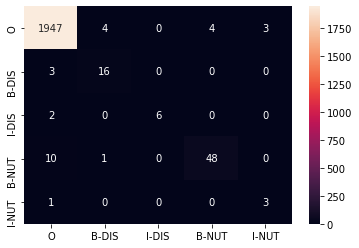

In [60]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.xaxis.set_ticklabels(['O', 'B-DIS', 'I-DIS', 'B-NUT', 'I-NUT'])
ax.yaxis.set_ticklabels(['O', 'B-DIS', 'I-DIS', 'B-NUT', 'I-NUT'])

### ===== looking at what is so hard to predict correct 

In [151]:
test_temp = test_sentences

test_temp1 = test_temp[1]

In [152]:
# word2Idx

In [153]:
Idx2word = {value: key for key, value in word2Idx.items()}

In [154]:
# Idx2word

In [155]:
Idx2word[0]

'PADDING_TOKEN'

In [156]:
# test_word = [Idx2word[i] for i in test_temp1]

In [157]:
### get a list of test_word sentences
test_words = []

for test_temp2 in test_temp:
    test_word = [Idx2word[i] for i in test_temp2]
    test_words.append(test_word)
    
### concat the test_words
test_words2 = []
for i in test_words:
    test_words2 += i

In [161]:
len(test_words2)

10120

In [162]:
len(concat_correct)

2048

In [163]:
len(test_labels)

374

[1, 2, 4, 4, 34, 54, 53]

### 4, Predictions

### 5, Prediction for a single sentence

In [29]:
test_sentence = """Periparturient diseases such as milk fever, ketosis, and displaced abomasums can all be associated with poor transition"""

length, masks, padded_inputs = predict_single_sentence(test_sentence, word2Idx, max_seq_len)
padded_inputs = tf.expand_dims(padded_inputs, 0)

true_labels = None
pred_labels = []
pred_logits = []

for sentence in padded_inputs:
    logits = testmodel(sentence)
    temp1 = tf.nn.softmax(logits) 
    max_values = tf.reduce_max(temp1,axis=-1)

    masked_max_values = max_values * masks 
    preds = tf.argmax(temp1, axis=2)
    pred_labels.append(np.asarray(preds))
    pred_logits.extend(np.asarray(masked_max_values))
_,label_pred  = idx_to_label(pred_labels, true_labels, idx2Label)



label_pred = label_pred[0][:length] 
pred_logits = pred_logits[0][:length]



### the splited sentences: words 


import re
from nltk import word_tokenize 

# remove punct 
words = str(test_sentence)
words = re.sub(r"[^a-zA-Z0-9.?! ]+", "", words)
words = words.lower()

# tokenize
words = word_tokenize(words)

# check for length 
print(len(words) == len(label_pred))
print()
print(words)
print(label_pred)

True

['periparturient', 'diseases', 'such', 'as', 'milk', 'fever', 'ketosis', 'and', 'displaced', 'abomasums', 'can', 'all', 'be', 'associated', 'with', 'poor', 'transition']
['O', 'O', 'O', 'O', 'O', 'O', 'B-DIS', 'O', 'B-DIS', 'I-DIS', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
